In [ ]:
! pip install numpy
! pip install tqdm
! pip install matplotlib

In [1]:
from enum import Enum

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Environment
We define a generic `GridWorldEnvironment` class to represent our simple problem and allow us to take actions on it.

In [2]:
class Action(Enum):
    LEFT = 0
    UP = 1
    RIGHT = 2
    DOWN = 3
    
    
    
class GridWorldEnvironment(object):
    def __init__(self, height, width, reward_pairs, invalid_action_reward=-10, step_reward=-1):
        """
        Initializes the environemnt for gridworld
        
        Args:
            height (int): The height of the environment
            width (int): The width of the environment
            reward_pairs (dict): The spectial transitions pairs, indicated by a dict having as key a tuple of the
                source cell coordinates and as value a tuple with the source cell coordinates and the reward
            invalid_action_reward (int): The reward given if invalid actions have been taken
            step_reward (int): The reward for a "normal" step taken.
        """
        self.height = height
        self.width = width
        
        self.reward_pairs = reward_pairs
        
        self.invalid_action_reward = invalid_action_reward
        self.step_reward = step_reward
        
        self.state = (0, 0)
        self.terminated = False
        
    def _compute_desired_next_state(self, state, action):
        if action == Action.LEFT:
            return (state[0], state[1] - 1)
        elif action == Action.RIGHT:
            return (state[0], state[1] + 1)
        elif action == Action.UP:
            return (state[0] - 1, state[1])
        elif action == Action.DOWN:
            return (state[0] + 1, state[1])
        
    def _is_permitted_state(self, desired_state):
        return (
            (desired_state[0] >= 0) and
            (desired_state[0] < self.height) and
            (desired_state[1] >= 0) and
            (desired_state[1] < self.width)
        )
        
    def act(self, action):
        """
        Performs an action in the current state.
        
        Args:
            action (Action or int): The action to take.
            
        Returns:
            int: The reward of taking this action
        """
        
        # If the current state is in one of the reward pairs any action will result
        # in a transition to the specified state and the specified reward.
        if self.state in reward_pairs:
            next_state, reward = self.reward_pairs[self.state]
            
            self.state = next_state            
            return reward
        else:
            desired_next_state = self._compute_desired_next_state(self.state, action)

            if self._is_permitted_state(desired_next_state):
                # For permitted actions, transition and return a reward of 0
                self.state = desired_next_state
                return self.step_reward
            else:
                # For not permitted actions, stay in the same state and give -1 reward
                return self.invalid_action_reward
            
    def reset(self):
        self.state = (0, 0)
        self.terminated = False
            
    def get_position_as_numpy(self):
        grid = np.zeros((self.height, self.width))
        grid[self.state] = 1
        
        return grid

Next we create an instance of this environment as given in `Example 3.5` in the book of [Sutton & Barto](http://incompleteideas.net/book/the-book-2nd.html). The example below was taken from that:

<img src="./gridworld_example_35_sutton_barto.png" alt="Example 3.5 Sutton & Barto" style="width:50%; margin:auto"/>

The implementation here does change the game from the example a bit. In the game from the example there is no incentive to move towards the optimal reward actions as quickly as possible. This makes the game much more instable and finding an optimal solution there does require some exploration strategy. Therefore we first create an instance of the game were we set the reward for taking an invalid action to `-10` and the reward for taking a allowed step that does not provide any payoff to `-1`.


In [3]:
reward_pairs = {
    (0, 1): ((4, 1), 10),
    (0, 3): ((2, 3), 5)
}

env = GridWorldEnvironment(5, 5, reward_pairs, invalid_action_reward=-1, step_reward=-0.05)

Let's take some actions and see that we traverse the grid properly

In [4]:
action_sequence = [Action.LEFT, Action.DOWN, Action.RIGHT, Action.UP, Action.UP]

total_reward = 0

print("Environment started in position (%d, %d)" % env.state)
for action in action_sequence:
    print("\nPerforming action %s" % action)
    total_reward += env.act(action)
    
    print("Transitioned to (%d, %d)" % env.state)
    print("Total reward is %d" % total_reward)

Environment started in position (0, 0)

Performing action Action.LEFT
Transitioned to (0, 0)
Total reward is -1

Performing action Action.DOWN
Transitioned to (1, 0)
Total reward is -1

Performing action Action.RIGHT
Transitioned to (1, 1)
Total reward is -1

Performing action Action.UP
Transitioned to (0, 1)
Total reward is -1

Performing action Action.UP
Transitioned to (4, 1)
Total reward is 8


# Q-learning
Let's set up the loop to estimate `Q(s, a)` iteratively. In this scenario we can nicely represent `Q` as a 3d-tensor that when indexing behaves like the function `Q` we are representing would.

In [34]:
ALPHA = 0.1
N_GAMES = 1000
MAX_ITER = 100
GAMMA = 1
EPSILON = 0.1


Q = np.zeros((env.height, env.width, len(Action)))

visited = np.zeros((env.height, env.width))

game_result = []
games_iterator = tqdm(range(N_GAMES))
for game in games_iterator:
    # Reset our environment such that we start with a clean slate
    env.reset()

    total_reward = 0
    i = 0
    while not env.terminated and i < MAX_ITER:
        current_state = env.state
        
        visited[current_state] += 1
        
        if np.random.rand() < EPSILON:
            action = Action(
                np.random.randint(Q.shape[-1])
            )
        else:
            # This is a slight variation of the traditional Q learning algorithm. However, this strategy allows for
            # a bit more exploration than only taking the maximum Q value found.
            action = Action(
                np.random.choice(
                    np.arange(Q.shape[-1]),
                    p=softmax(Q[current_state])
                )
            )

        reward = env.act(action)
        new_state = env.state
             

        Q[(*current_state, action.value)] = (
            Q[(*current_state, action.value)] + ALPHA * (reward + GAMMA * np.max(Q[new_state]) - Q[(*current_state, action.value)])
        )
        
        total_reward += reward
        i += 1
        
    game_result.append(total_reward)
    
    games_iterator.set_description('Average reward %.2f' % np.array(game_result).mean())
    
    

Average reward 172.75: 100%|██████████| 1000/1000 [00:10<00:00, 95.35it/s]


# Results
We plot the results per game. We see that the algorithm easily learns to find good strategies. However, due to the non-deminishing explorarion rate $\epsilon=0.1$ we see that the game starts oscilating around a maximum reward.

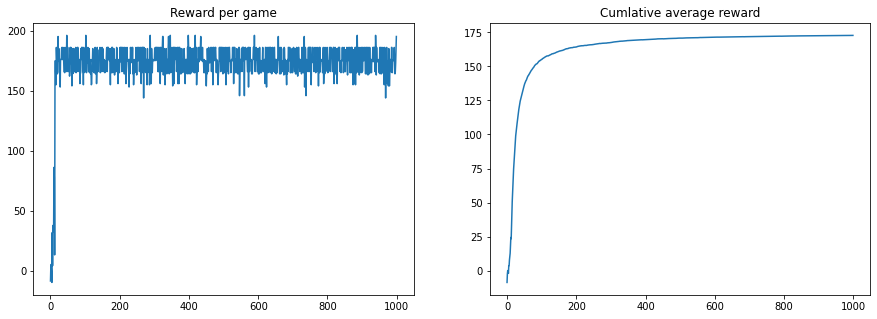

In [35]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 5))

axs[0].set_title('Reward per game')
axs[0].plot(np.array(game_result))

axs[1].set_title('Cumlative average reward')
axs[1].plot(np.array(game_result).cumsum() / np.arange(1, len(game_result)+1))

The best action in every state $s$ can be found by simply taking $argmax_{a} Q(s, a)$. This gives an optimal action in every state which in our case is a move in a certain direction. The plot below shows the optimal moves found for every state.

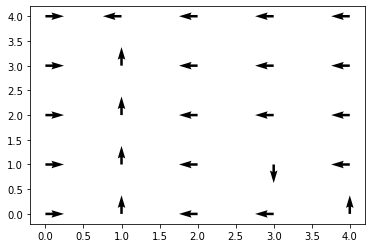

In [36]:
best_actions = np.argmax(Q, axis=-1)

left = (best_actions == Action.LEFT.value)
right = (best_actions == Action.RIGHT.value)
up = (best_actions == Action.UP.value)
down = (best_actions == Action.DOWN.value)

vectors = np.zeros((Q.shape[0], Q.shape[1], 2))

vectors[..., 0] += up
vectors[..., 0] -= down

vectors[..., 1] += right
vectors[..., 1] -= left

X, Y = np.meshgrid(np.arange(Q.shape[0]), np.arange(Q.shape[1])[::-1])
YX = np.concatenate([Y[ ..., None], X[..., None]], axis=-1).reshape((-1, 2))

plt.quiver(YX[..., 1], YX[..., 0], vectors[..., 1].reshape(-1), vectors[..., 0].reshape(-1))